# Practice: simple question answering
![img](https://www.cs.upc.edu/~mlatifi/index_files/qa-logo.jpg)

Today we're going to build a retrieval-based question answering model with metric learning models.

_this seminar is based on original notebook by [Oleg Vasilev](https://github.com/Omrigan/)_



In [1]:
!which python

/home/iris/paulshab/NLP_env/nlp_environ/bin/python


In [ ]:
"""
Compare several open-sourced methods for QA(Information Retrieval), 
find simple and effective method. 
(Frameworks for information retrieval)
""" 

In [1]:
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import data

[nltk_data] Downloading package punkt to /home/iris/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Dataset

Today's data is Stanford Question Answering Dataset (SQuAD). Given a paragraph of text and a question, our model's task is to select a snippet that answers the question.

We are not going to solve the full task today. Instead, we'll train a model to __select the sentence containing answer__ among several options.

As usual, you are given an utility module with data reader and some helper functions

In [2]:
# !pip install transformers
# !wget https://raw.githubusercontent.com/yandexdataschool/nlp_course/2020/week11_conversation/data.py -O data.py
# !wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O squad-v2.0.json 2> log


# backup download link: https://www.dropbox.com/s/q4fuihaerqr0itj/squad.tar.gz?dl=1
train, test = data.build_dataset('./squad-v2.0.json')

In [3]:
train

,paragraph_id,question,options,correct_indices,wrong_indices
0,0,When did Beyonce start becoming popular?,[Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ ...,[1],"[0, 2, 3]"
1,0,What areas did Beyonce compete in when she was...,[Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ ...,[1],"[0, 2, 3]"
2,0,When did Beyonce leave Destiny's Child and bec...,[Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ ...,[3],"[0, 1, 2]"
3,0,In what city and state did Beyonce grow up?,[Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ ...,[1],"[0, 2, 3]"
4,0,In which decade did Beyonce become famous?,[Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ ...,[1],"[0, 2, 3]"
...,...,...,...,...,...
85121,56,What is Nepal's primary airport for internatio...,[The main international airport serving Kathma...,[0],"[1, 2, 3, 4, 5]"
85122,56,"Starting in the center of Kathmandu, how many ...",[The main international airport serving Kathma...,[0],"[1, 2, 3, 4, 5]"
85123,56,How many airlines use Tribhuvan International ...,[The main international airport serving Kathma...,[2],"[0, 1, 3, 4, 5]"
85124,56,From what city does Arkefly offer nonstop flig...,[The main international airport serving Kathma...,[3],"[0, 1, 2, 4, 5]"


In [4]:
train['options'][40]

['Beyoncé Giselle Knowles was born in Houston, Texas, to Celestine Ann "Tina" Knowles (née Beyincé), a hairdresser and salon owner, and Mathew Knowles, a Xerox sales manager.',
 "Beyoncé's name is a tribute to her mother's maiden name.",
 "Beyoncé's younger sister Solange is also a singer and a former member of Destiny's Child.",
 'Mathew is African-American, while Tina is of Louisiana Creole descent (with African, Native American, French, Cajun, and distant Irish and Spanish ancestry).',
 'Through her mother, Beyoncé is a descendant of Acadian leader Joseph Broussard.',
 'She was raised in a Methodist household.']

In [5]:
pid, question, options, correct_indices, wrong_indices = train.iloc[40]
print('QUESTION', question, '\n')
for i, cand in enumerate(options):
    print(['[ ]', '[v]'][i in correct_indices], cand)

QUESTION Where did Beyonce get her name from? 

[ ] Beyoncé Giselle Knowles was born in Houston, Texas, to Celestine Ann "Tina" Knowles (née Beyincé), a hairdresser and salon owner, and Mathew Knowles, a Xerox sales manager.
[v] Beyoncé's name is a tribute to her mother's maiden name.
[ ] Beyoncé's younger sister Solange is also a singer and a former member of Destiny's Child.
[ ] Mathew is African-American, while Tina is of Louisiana Creole descent (with African, Native American, French, Cajun, and distant Irish and Spanish ancestry).
[ ] Through her mother, Beyoncé is a descendant of Acadian leader Joseph Broussard.
[ ] She was raised in a Methodist household.


### Pre-trained BERT
_(but you guessed it)_

We've already solved quite a few tasks from scratch, training our own embeddings and convolutional/recurrent layers. However, one can often achieve higher quality by using pre-trained models. We will default to the good ol' [BERT](https://arxiv.org/abs/1810.04805), though, you are free to use any [other model](https://huggingface.co/models) as you see fit.


In [12]:
from transformers import AutoTokenizer, AutoModel, pipeline

model_name = 'sentence-transformers/bert-base-nli-mean-tokens'
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert = AutoModel.from_pretrained(model_name)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [7]:
# just a reminder: here's how it works
dummy_lines = [
    "How old are you?",                                                 # 0
    "In what mythology do two canines watch over the Chinvat Bridge?",  # 1
    "I'm sorry, okay, I'm not perfect, but I'm trying.",                # 2
    "What is your age?",                                                # 3
    "Beware, for I am fearless, and therefore powerful.",               # 4
]

bert.to('cpu')
with torch.no_grad():
    batch_tensors = tokenizer(dummy_lines, padding=True, max_length=25, truncation=True, return_tensors="pt")
    output =  bert(**batch_tensors)
    token_embs = output.last_hidden_state
    cls_embs = output.pooler_output
    
    
mask = batch_tensors['attention_mask'][..., None].to(torch.float32)
naive_phrase_embs = (token_embs * mask).sum(1) / mask.sum(1)   ## uses token_embs instead of pooler outout

In [43]:
token_embs.shape

torch.Size([5, 21, 768])

In [306]:
(token_embs * mask).sum(1).shape

torch.Size([5, 768])

In [8]:
print(cls_embs.shape)
print(token_embs.shape)

torch.Size([5, 768])
torch.Size([5, 21, 768])


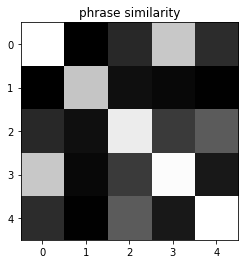

In [9]:
plt.title('phrase similarity')
plt.imshow((naive_phrase_embs @ naive_phrase_embs.t()).cpu().data.numpy(), interpolation='none', cmap='gray')

As you can see, __the strongest similarity is between lines 0 and 3__. Indeed they correspond to "How old are you?" and "What is your age?"

### Model (2 points)

Our goal for today is to build a model that measures similarity between question and answer. In particular, it maps both question and answer into fixed-size vectors such that:

Our model is a pair of $V_q(q)$ and $V_a(a)$ - networks that turn phrases into vectors. 

__Objective:__ Question vector $V_q(q)$ should be __closer__ to correct answer vectors $V_a(a^+)$ than to incorrect ones $V_a(a^-)$ .

Both vectorizers can be anything you wish. For starters, let's use a couple of dense layers on top of the pre-trained encoder.




In [15]:
class Vectorizer(nn.Module):
    def __init__(self, hid_size=256, bert=bert, device="cpu"):
        """ A small feedforward network on top of pre-trained encoder. 2-3 layers should be enough """
        super().__init__()
        self.bert = bert.to(device).eval()
        self.device = device
        self.hid_size = hid_size
        
        # define a few layers to be applied on top of pre-trained BERT
        # note: please make sure your final layer comes with _linear_ activation
        
        self.encoder = nn.Sequential(
          nn.Linear(768, 384),
          nn.ReLU(),
          nn.Dropout(p=0.1),
          nn.Linear(384, self.hid_size),
          #nn.Sigmoid() 
        )
        
#         self.decoder = nn.Sequential(
#           nn.Linear(self.hid_size, 384),
#           nn.ReLU(),
#           nn.Dropout(p=0.1),
#           nn.Linear(384, 768),
#         )
        
        
    def forward(self, input_phrases):
        """
        Apply vectorizer. Use dropout and any other hacks at will.
        :param input_phrases: a list of strings, [batch_size]
        :returns: predicted phrase vectors, [batch_size, output_size]
        
        Note: you may want to use dropouts.
        if self.training:
          <something>
        
        Note 2: you may also want to use with torch.no_grad to avoid training BERT for your first attempts
        
        """
        
        with torch.no_grad():
            batch_tensors = tokenizer(input_phrases, padding=True, max_length=25, truncation=True, return_tensors="pt").to(self.device)
            output =  bert(**batch_tensors)
            token_embs = output.last_hidden_state
            cls_embs = output.pooler_output
        
        mask = batch_tensors['attention_mask'][..., None].to(torch.float32)
        naive_phrase_embs = (token_embs * mask).sum(1) / mask.sum(1)        # take cls??
        #print(naive_phrase_embs.shape)
        
        encoder_output = self.encoder(naive_phrase_embs)
        #decoder_output = self.decoder(encoder_output)
        
        # In fact, please DO use at least 10% dropout!
  
        return encoder_output

In [17]:
question_vectorizer = Vectorizer()
answer_vectorizer = Vectorizer()

question_vectorizer(dummy_lines)

tensor([[-0.2968,  0.0464,  0.0179,  ..., -0.2580,  0.3096, -0.1261],
        [ 0.1324, -0.1383, -0.0142,  ...,  0.1157,  0.2497, -0.2907],
        [ 0.0517, -0.0574,  0.0802,  ..., -0.1719, -0.1148, -0.2715],
        [-0.1334,  0.0713, -0.0550,  ..., -0.1453,  0.2972, -0.2615],
        [-0.0428, -0.0025,  0.1669,  ..., -0.1976,  0.1789,  0.0110]],
       grad_fn=<AddmmBackward>)

In [18]:
dummy_lines

['How old are you?',
 'In what mythology do two canines watch over the Chinvat Bridge?',
 "I'm sorry, okay, I'm not perfect, but I'm trying.",
 'What is your age?',
 'Beware, for I am fearless, and therefore powerful.']

In [19]:
question_vectorizer.train(False)
out1 = question_vectorizer(dummy_lines)
out2 = question_vectorizer(dummy_lines)
assert tuple(out1.shape) == (5, question_vectorizer.hid_size)
assert torch.allclose(out1, out2, atol=1e-5, rtol=0), "Make sure your model disables dropout if training == False"
print("Well done!")

Well done!


### Training: minibatches

Our model learns on triples $(q, a^+, a^-)$: 
* q - __q__uestion
* (a+) - correct __a__nswer
* (a-) - wrong __a__nswer 

Below you will find a generator that samples such triples from data.

In [ ]:
# Deep Semantic Similarity Model

In [14]:
train.sample(3)

,paragraph_id,question,options,correct_indices,wrong_indices
45348,1,What is another university in the triangle?,[Raleigh is home to North Carolina State Unive...,[0],"[1, 2, 3]"
33875,16,Maria Deraismes and who else started a mixed m...,[Maria Deraismes was initiated into Freemasonr...,[1],"[0, 2, 3, 4, 5]"
81885,36,How much did banks estimate was the value of C...,"[For a variety of reasons, market participants...",[2],"[0, 1]"


In [20]:
import random

def iterate_minibatches(data, batch_size, shuffle=True, cycle=False):
    """
    Generates minibatches of triples: {questions, correct answers, wrong answers}
    If there are several wrong (or correct) answers, picks one at random.
    """
    indices = np.arange(len(data))
    while True:
        if shuffle:
            indices = np.random.permutation(indices)
        for batch_start in range(0, len(indices), batch_size):
            batch_indices = indices[batch_start: batch_start + batch_size]
            batch = data.iloc[batch_indices]
            questions = batch['question'].values
            correct_answers = np.array([
                row['options'][random.choice(row['correct_indices'])]
                for i, row in batch.iterrows()
            ])
            wrong_answers = np.array([
                row['options'][random.choice(row['wrong_indices'])]
                for i, row in batch.iterrows()
            ])

            yield {
                'questions' : questions,
                'correct_answers': correct_answers,
                'wrong_answers': wrong_answers,
            }
        if not cycle:
            break

In [22]:
dummy_batch = next(iterate_minibatches(train.sample(3), 3))
print("\n", dummy_batch['questions'])
print("\n", dummy_batch['correct_answers'])
print("\n", dummy_batch['wrong_answers'])


 ['What type of kings brought the Gothic style from France to Southern Italy?'
 'During which era did universities grow out of already extant schools?'
 'According to Thompson v. Oklahoma, what was the youngest age at which a person might be executed?']

 ['Angevin kings brought the Gothic tradition from France to Southern Italy, while Lusignan kings introduced French Gothic architecture to Cyprus.'
 'In the early medieval period, most new universities were founded from pre-existing schools, usually when these schools were deemed to have become primarily sites of higher education.'
 'Sixteen was held to be the minimum permissible age in the 1988 Supreme Court decision of Thompson v. Oklahoma.']

 ['At the end of the 12th century, Europe was divided into a multitude of city states and kingdoms.'
 'European higher education took place for hundreds of years in Christian cathedral schools or monastic schools (scholae monasticae), in which monks and nuns taught classes; evidence of these i

### Training: loss function (2 points)
We want our vectorizers to put correct answers closer to question vectors and incorrect answers farther away from them. One way to express this is to use is Pairwise Hinge Loss _(aka Triplet Loss)_. 

$$ L = \frac 1N \underset {q, a^+, a^-} \sum max(0, \space \delta - sim[V_q(q), V_a(a^+)] + sim[V_q(q), V_a(a^-)] )$$

, where
* sim[a, b] is some similarity function: dot product, cosine or negative distance
* δ - loss hyperparameter, e.g. δ=1.0. If sim[a, b] is linear in b, all δ > 0 are equivalent.


This reads as __Correct answers must be closer than the wrong ones by at least δ.__

![img](https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/margin.png)
<center>_image: question vector is green, correct answers are blue, incorrect answers are red_</center>


Note: in effect, we train a Deep Semantic Similarity Model [DSSM](https://www.microsoft.com/en-us/research/project/dssm/). 

In [32]:
def similarity(a, b, device="cpu"):
    """ 
    
    - Dot product as a similarity function
    - cosine similarity between A and B
    
    """
    
    #cos_sim =(a * b).sum(axis=1)/(torch.norm(a, dim=1)*torch.norm(b, dim=1))
    cos_sim =(a * b).sum(axis=1)
    #print (f"Cosine Similarity between A and B:{cos_sim}")
   
    return cos_sim 

def compute_loss(question_vectors, correct_answer_vectors, wrong_answer_vectors, delta=1.0):
    """ 
    Compute the triplet loss as per formula above.
    Use similarity function above for  sim[a, b]
    :param question_vectors: float32[batch_size, vector_size]
    :param correct_answer_vectors: float32[batch_size, vector_size]
    :param wrong_answer_vectors: float32[batch_size, vector_size]
    :returns: loss for every row in batch, float32[batch_size]
    Hint: you can compute max(0, *) using torch.relu :)
    """
    
    relu = nn.ReLU()
    lenght = question_vectors.shape[1]
    delta = torch.full((lenght , 1), delta)  ## put to device
    
    loss =  torch.mean(relu(delta - similarity(question_vectors,  correct_answer_vectors) + 
                    similarity(question_vectors,  wrong_answer_vectors)), axis=0) 

    return loss

In [33]:
dummy_v1 = torch.tensor([[0.1, 0.2, -1], [-1.2, 0.6, 1.0]], dtype=torch.float32)
dummy_v2 = torch.tensor([[0.9, 2.1, -6.6], [0.1, 0.8, -2.2]], dtype=torch.float32)
dummy_v3 = torch.tensor([[-4.1, 0.1, 1.2], [0.3, -1, -2]], dtype=torch.float32)

assert np.allclose(similarity(dummy_v1, dummy_v2).data.numpy(), [7.11, -1.84])

assert np.allclose(compute_loss(dummy_v1, dummy_v2, dummy_v3, delta=5.0).data.numpy(), [0.0, 3.88])

compute_loss(dummy_v1, dummy_v2, dummy_v3, delta=5.0)
#similarity(dummy_v1, dummy_v2)

tensor([0.0000, 3.8800])

In [34]:
print(similarity(dummy_v1, dummy_v2).data.numpy())
print(compute_loss(dummy_v1, dummy_v2, dummy_v3, delta=5.0).data.numpy())
np.allclose(compute_loss(dummy_v1, dummy_v2, dummy_v3, delta=5.0).data.numpy(), [0.0, 3.88])

[ 7.1099997 -1.84     ]
[0.   3.88]


True

Once loss is working, let's train our model by our usual means.

In [35]:
# we also compute recall: the rate at which a^+ is closer to q than a^-

vectorizer = Vectorizer()
question_vectorizer = Vectorizer()
answer_vectorizer = Vectorizer()

def get_recall(questions, correct_answers, wrong_answers, model):

    v_questions = model(list(questions))
    v_correct = model(list(correct_answers))
    v_incorrect = model(list(wrong_answers))

    correct_is_closer = similarity(v_questions, v_correct) > similarity(v_questions, v_incorrect)
    
    recall = torch.mean(correct_is_closer.to(torch.float32)).item()
    
    return recall

In [40]:
#make sure it works
get_recall(**dummy_batch, model)
get_recall(dummy_batch['questions'], dummy_batch['correct_answers'], dummy_batch['wrong_answers'], model=vectorizer )

SyntaxError: positional argument follows keyword argument unpacking (1183671203.py, line 2)

In [36]:
print(list(dummy_batch['questions'])[0])

print("\n", list(dummy_batch['correct_answers'])[0])

print("\n", list(dummy_batch['wrong_answers'])[0])

What type of kings brought the Gothic style from France to Southern Italy?

 Angevin kings brought the Gothic tradition from France to Southern Italy, while Lusignan kings introduced French Gothic architecture to Cyprus.

 At the end of the 12th century, Europe was divided into a multitude of city states and kingdoms.


### Training loop

Just as we always do, we can now train DSSM on minibatches and periodically measure recall on validation data.


__Note 1:__ DSSM training may be very sensitive to the choice of batch size. Small batch size may decrease model quality.

__Note 2:__ here we use the same dataset as __"test set"__ and __"validation (dev) set"__. 

In any serious scientific experiment, those must be two separate sets. Validation is for hyperparameter tuning and test is for final eval only.


In [312]:
import pandas as pd
from IPython.display import clear_output
from tqdm import tqdm
import torch.optim as optim


# Initialize model, optimizers, anything else you want
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

vectorizer = Vectorizer(bert=bert, device=device)

vectorizer.to(device)
vectorizer.train() 

    
#criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vectorizer.parameters(), lr=0.0001)


ewma = lambda x, span: pd.DataFrame({'x': x})['x'].ewm(span=span).mean().values    # where to use this?
dev_batches = iterate_minibatches(test, batch_size=256, cycle=True)
loss_history = []
dev_recall_history = []

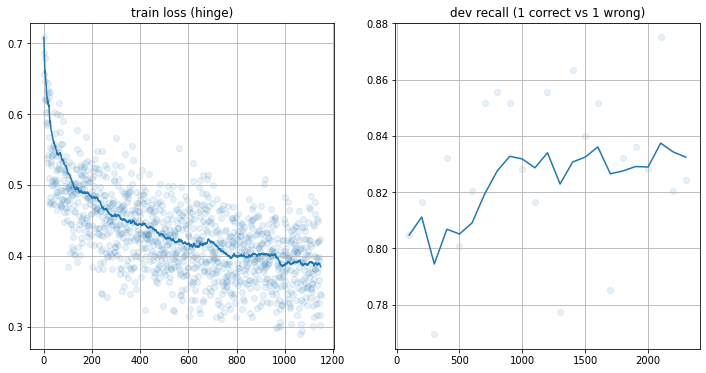

KeyboardInterrupt: 

In [314]:
# infinite training loop. Stop it manually or implement early stopping

for batch in iterate_minibatches(train, batch_size=256, cycle=True):
    
    # Perform one training step
    
    v_questions = vectorizer(list(batch['questions']))
    v_correct = vectorizer(list(batch['correct_answers']))
    v_incorrect = vectorizer(list(batch['wrong_answers']))
    
    assert v_questions.device.type == "cuda" and v_correct.device.type == "cuda" and v_incorrect.device.type == "cuda", "Oh no! This assertion failed!"

    loss_t = torch.mean(compute_loss(v_questions, v_correct, v_incorrect, delta=1.0))
    loss_history.append(float(loss_t))
    
    loss_t.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if len(loss_history) % 50 == 0:
        # measure dev recall = P(correct_is_closer_than_wrong | q, a+, a-)
        dev_batch = next(dev_batches)
        
        recall_t = get_recall(batch['questions'], batch['correct_answers'], batch['wrong_answers'], model=vectorizer)
        
        dev_recall_history.append(recall_t)
    
    if len(loss_history) % 50 == 0:
        clear_output(True)
        plt.figure(figsize=[12, 6])
        plt.subplot(1, 2, 1), plt.title('train loss (hinge)'), plt.grid()
        plt.scatter(np.arange(len(loss_history)), loss_history, alpha=0.1)
        plt.plot(ewma(loss_history, span=100))
        plt.subplot(1, 2, 2), plt.title('dev recall (1 correct vs 1 wrong)'), plt.grid()
        dev_time = np.arange(1, len(dev_recall_history) + 1) * 100
        plt.scatter(dev_time, dev_recall_history, alpha=0.1)
        plt.plot(dev_time, ewma(dev_recall_history, span=10))
        plt.show()
    

In [282]:
print("Mean recall:", np.mean(dev_recall_history[-10:]))
assert np.mean(dev_recall_history[-10:]) > 0.85, "Please train for at least 85% recall on test set. "\
                                                  "You may need to change vectorizer model for that."
print("Well done!")

Mean recall: 0.521875


AssertionError: Please train for at least 85% recall on test set. You may need to change vectorizer model for that.

# Final evaluation (1 point)

Let's see how well does our model perform on actual question answering. 

Given a question and a set of possible answers, pick answer with highest similarity to estimate accuracy.

In [ ]:
# optional: any additional preparations, e.g. build index
# <...>

def select_best_answer(question, possible_answers):
    """
    Predicts which answer best fits the question
    :param question: a single string containing a question
    :param possible_answers: a list of strings containing possible answers
    :returns: integer - the index of best answer in possible_answer
    """
    <YOUR CODE>
    return <...>
    

In [ ]:
predicted_answers = [
    select_best_answer(question, possible_answers)
    for i, (question, possible_answers) in tqdm(test[['question', 'options']].iterrows(), total=len(test))
]

accuracy = np.mean([
    answer in correct_ix
    for answer, correct_ix in zip(predicted_answers, test['correct_indices'].values)
])
print("Accuracy: %0.5f" % accuracy)
assert accuracy > 0.65, "we need more accuracy!"
print("Great job!")

In [ ]:
def draw_results(question, possible_answers, predicted_index, correct_indices):
    print("Q:", question, end='\n\n')
    for i, answer in enumerate(possible_answers):
        print("#%i: %s %s" % (i, '[*]' if i == predicted_index else '[ ]', answer))
    
    print("\nVerdict:", "CORRECT" if predicted_index in correct_indices else "INCORRECT", 
          "(ref: %s)" % correct_indices, end='\n' * 3)

In [ ]:
for i in [1, 100, 1000, 2000, 3000, 4000, 5000]:
    draw_results(test.iloc[i].question, test.iloc[i].options,
                 predicted_answers[i], test.iloc[i].correct_indices)

In [ ]:
question = "What is my name?" # your question here!
possible_answers = [
    <...> 
    # ^- your options. 
]
predicted answer = select_best_answer(question, possible_answers)

draw_results(question, possible_answers,
             predicted_answer, [0])

### Bonus tasks

There are many ways to improve our question answering model. Here's a bunch of things you can do to increase your understanding and get bonus points.

### 1.  Hard Negatives (3+ pts)

Not all wrong answers are equally wrong. As the training progresses, _most negative examples $a^-$ will be to easy._ So easy in fact, that loss function and gradients on such negatives is exactly __0.0__. To improve training efficiency, one can __mine hard negative samples__.

Given a list of answers,
* __Hard negative__ is the wrong answer with highest similarity with question,

$$a^-_{hard} = \underset {a^-} {argmax} \space sim[V_q(q), V_a(a^-)]$$

* __Semi-hard negative__ is the one with highest similarity _among wrong answers that are farther than positive one. This option is more useful if some wrong answers may actually be mislabelled correct answers.

* One can also __sample__ negatives proportionally to $$P(a^-_i) \sim e ^ {sim[V_q(q), V_a(a^-_i)]}$$


The task is to implement at least __hard negative__ sampling and apply it for model training.


### 2. Bring Your Own Model (3+ pts)
In addition to BERT, one can also train a new model.
* You name it: convolutions, RNN, self-attention (beware, it may need pre-training data)
* Combine multple bert-like models
* Monitor overfitting and use dropout / word dropout to improve performance

* hard negatives (strategies: hardest, hardest farter than current, randomized)
* train model on the full dataset to see if it can mine answers to new questions over the entire wikipedia. Use approximate nearest neighbor search for fast lookup.


### 3. Search engine (3+ pts)

Our basic model only selects answers from 2-5 available sentences in paragraph. You can extend it to search over __the whole dataset__. All sentences in all other paragraphs are viable answers.

The goal is to train such a model and use it to __quickly find top-10 answers from the whole set__.

* You can ask such model a question of your own making - to see which answers it can find among the entire training dataset or even the entire wikipedia.
* Searching for top-K neighbors is easier if you use specialized methods: [KD-Tree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html) or [HNSW](https://github.com/nmslib/hnswlib). 
* This task is much easier to train if you use hard or semi-hard negatives. You can even find hard negatives for one question from correct answers to other questions in batch - do so in-graph for maximum efficiency. See [1.] for more details.
